In [20]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings("ignore")

In [22]:
# Configure load path
import pickle
import pandas as pd
import os
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score, d2_absolute_error_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import xgboost as xgb
from dateutil.relativedelta import relativedelta
from tqdm import tqdm, tqdm_notebook
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.tree    import DecisionTreeRegressor
from sklearn.tree    import DecisionTreeClassifier
import itertools

os.chdir("C:/Users/Win11/Documents/Repos/Acorn-Casino-PLTV/")

bs_token = 'S7Fek4qridIxY1sUfYUyOl0rLak1Eedeg0TTCWHzUHqIFuUGN07xZtd41ZCp2UvE'  # Token Bingo Arena
host = 'td.winnerstudio.vip'

# Path Thinking Engine tables
tables_path = 'pltv_lucky_accorn_ios_tables.py'
start_date = (datetime.now() - timedelta(days = 80)).strftime('%Y-%m-%d')
end_date = (datetime.now() - timedelta(days = 29)).strftime('%Y-%m-%d')
client_name = 'ios'

# Load queries from remote python script (This needs to be perfect).  Overall, you might want to have the lsit here
exec(open(tables_path).read())
tables = locals().get('tables')

In [21]:
with open('acorn_ios_ptlv_dictionary_2024_jan.pkl', 'rb') as file:
    model_dict = pickle.load(file)
model_dict.head()

,Available day,Target day,Model,Columns
0,7,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
1,8,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
2,9,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
3,10,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
4,11,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."


## 1. Load the data and incorporate the predictions 

This should be everything that you can get from the previous step, except the API data 

In [23]:
def load_data(tables, bs_token, host):
    def pull_data(sql_script, bs_token, host):

        data = {
            'token':          bs_token,
            'format':         'json_object',
            'timeoutSeconds': 2000,
            'sql':            sql_script
        }

        data = str(urlencode(data))
        response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)

        # Sample list of JSON strings
        json_list = response.text.split('\n')[1:]

        # Convert JSON strings to dictionaries
        dict_list = []
        for json_str in json_list:
            try:
                dict_list.append(json.loads(json_str))
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON: {e}")

        # Create a pandas DataFrame
        data = pd.DataFrame(dict_list).sort_index(axis = 1)
        print(data)
        # Display the DataFrame
        return data

    # Load the first data using USER_PAYMENT, and then iteatevely join the remaining data for trainning

    df = pull_data(tables[0], bs_token, host)
    for i in range(1, len(tables)):
        new_data = pull_data(tables[i], bs_token, host)
        df = df.merge(new_data, on = '#account_id', how = 'left')

    return df

# Load queries from remote python script (This needs to be perfect).  Overall, you might want to have the lsit here
exec(open(tables_path).read())
tables = locals().get('tables')
training_columns = locals().get('training_columns')
training_columns_feb = locals().get('training_columns_feb')

# Create df by loading information and joining on account_id
df = load_data(tables, bs_token, host)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
       #account_id  cp1  cp3  cp7   p1    p10   p100   p105    p11   p112  \
0           145966    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
1           146000    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
2           146405    0    0    0  0.0  4.435  4.435  4.435  4.435  4.435   
3           147245    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
4         10024061    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
...            ...  ...  ...  ...  ...    ...    ...    ...    ...    ...   
173217    10180179    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
173218    10180192    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
173219    10180212    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
173220    10180602    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   
173221    10180768    0    0    0  0.0  0.000  0.000  0.000  0.000  0.000   

        ...  

In [68]:
# Data preprocessing and transformations
df['#account_id'] = df['#account_id'].astype(str)
df['register_time'] = pd.to_datetime(df['register_time'], errors = 'coerce')
df['date'] = df['register_time'].dt.strftime('%Y%m%d').astype(float)  # Change to float if needed

df = df.fillna(0)

In [69]:
# Calculate differences
day_columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']
for i in range(len(day_columns) - 1, 0, -1):
    df[f'{day_columns[i]}_diff'] = df[day_columns[i]] - df[day_columns[i - 1]]

In [70]:
# Add predictions
integers_list = list(range(7, 28))
incremented_numbers = [str(number) for number in range(28, 36, 7)]
predictors_days_input = predictors_days = [str(integer) for integer in integers_list] + incremented_numbers

# Available dates as target (I am considering adding more values, above and below, maybe up to two on each side)
response_days_input = response_days = ["14", "28", "56", "63", "70", "77", "84", "91", "98", "100", "105", "112", "119", "126", "133"]
def add_predictions(data, model_dict, response_days, predictors_days):

    for response in response_days:
        data[f'actual_{response}'] = data[f'p{response}'] - data[f'w{response}']

        for reg in predictors_days:

            if int(response) > int(reg):
                
                data[f'p_last_diff_7_{reg}'] = data[f'p{reg}'] - data[f'p7']
                data[f'w_last_diff_7_{reg}'] = data[f'w{reg}'] - data[f'w7']
                columns = list((model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)][['Columns']].reset_index(drop=True).values[0])[0]) #+ [f'p_last_diff_7_{reg}'] + [f'w_last_diff_7_{reg}']
                
                # Load the model
                model = model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)]['Model'].reset_index(drop=True).values[0]

                # Make the prediction (Make sure is done only for those on which makese sense)
                prediction = model.predict(data[columns])
                data[f'pred_{reg}_{response}'] = prediction + data[f'p{reg}']- data[f'w{reg}']
                del data[f'p_last_diff_7_{reg}']
                del data[f'w_last_diff_7_{reg}']

    return data

df = add_predictions(df, model_dict, response_days_input, predictors_days_input)

## 2. Add media source 

Add the media source

In [71]:
api_details = {'bundle_id': 'com.acorncasino.slots', 'start': start_date, 'end':  end_date}
api_url = 'http://acorncasino-ios.twilightgift.club/server/media_source_cost'

# Send a GET request to the API
response = requests.post(api_url, api_details)
if response.status_code == 200:
    # Request was successful
    api_df = response.json()  # Parse the JSON response if the API returns JSON data
    api_df = pd.DataFrame(api_df['data'])
    api_df['api_installs'] = api_df['user_ids'].apply(lambda x: len([int(item.strip()) for item in x.split(",") if item.strip()]))
    print('Loaded', api_df.shape)
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


Loaded (231, 7)


In [72]:
api_df = api_df.groupby('date')[['cost', 'revenue_d7', 'withdraw_d7', 'api_installs']].sum().reset_index(drop = False).sort_values(by = 'date')
api_df.head()

,date,cost,revenue_d7,withdraw_d7,api_installs
0,20231107,5118.22,5365.69,3075.03,778
1,20231108,5957.26,8082.24,5636.90,832
2,20231109,6571.56,5113.44,2044.53,835
3,20231110,6888.82,5565.94,2926.28,882
4,20231111,6935.93,3301.68,1098.13,862


In [77]:
n_values = df.columns[df.columns.str.match(r'pred_\d+_\d+')].str.extract(r'pred_\d+_(\d+)').dropna()[0].unique() # These are the responses, after removing the availables.
available_k_values = [int(col.split('_')[1]) for col in df.columns if col.startswith('pred_')] # What are the numbers after 'pred_'
pred_list = ['pred_14', 'pred_28', 'pred_56', 'pred_63', 'pred_70', 'pred_77', 'pred_84', 'pred_91', 'pred_98', 'pred_100', 'pred_105', 'pred_112', 'pred_119', 'pred_126', 'pred_133']

df['te_installs'] = 1
agg_df = df.fillna(0).groupby('date')[[col for col in df.columns if col.startswith("p") or col.startswith("w") or col.startswith("ad") or col.startswith("act") or col.startswith("actual_")] + ['te_installs']].sum().reset_index()
agg_df = api_df[['date', 'api_installs', 'cost', 'revenue_d7', 'withdraw_d7']].merge(agg_df, on = 'date', how = 'inner')

agg_df['payment_increase']    = (agg_df['revenue_d7'] - agg_df['p7']) / agg_df['p7']
agg_df['rpi_increase']        = ((agg_df['revenue_d7'] / agg_df['api_installs'].astype(float)) - (agg_df['p7'] / agg_df['te_installs']) / (agg_df['p7'] / agg_df['te_installs']))
agg_df['installs_difference'] = (agg_df['api_installs'] - agg_df['te_installs']) / agg_df['te_installs'] # ['Install', 'installs']'Install' is API
agg_df['withdrawn_ratio']     = agg_df['withdraw_d7'] / agg_df['revenue_d7']
agg_df['return_p_d7']         = agg_df['p7'] / agg_df['cost'] 
agg_df['return_ad_d7']        = agg_df['ad7'] / agg_df['cost'] 
today = pd.to_datetime((datetime.now() - timedelta(days = 1)).strftime('%Y-%m-%d'))


In [78]:
# Generate pred roas cols by dividing pred_revenue by spending (Name does not change)
agg_df[[col for col in df.columns if col.startswith("pred_")]] = agg_df[[col for col in df.columns if col.startswith("pred_")]].div(agg_df['cost'], axis = 0)

In [79]:
agg_df_train = agg_df[['date'] + ['cost'] + ['revenue_d7'] + ['withdraw_d7'] + ['payment_increase'] + ['rpi_increase'] + ['installs_difference'] + ['withdrawn_ratio'] 
                        + [col for col in agg_df.columns if col.startswith("pred_")] + [col for col in agg_df.columns if col.startswith("w")]]

agg_df_train.sample(10)

,date,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,pred_7_14,pred_8_14,...,w63,w7,w70,w77,w8,w84,w9,w91,w98,withdrawn_ratio
0,20231107,5118.22,5365.69,3075.03,-0.555991,5.896774,-0.686164,0.573091,1.210758,1.614339,...,16950.7000,6920.39,16950.7000,16950.7000,7655.39,16950.7000,7865.39,16950.7000,16950.7000,0.573091
8,20231115,6644.43,4699.35,1466.96,-0.682695,4.407768,-0.632247,0.312162,1.671601,1.754243,...,18774.4000,4899.48,18774.4000,18774.4000,5630.43,18774.4000,6212.00,18774.4000,18774.4000,0.312162
13,20231120,8106.46,7655.95,3827.72,-0.246024,6.565168,-0.249815,0.499967,0.923635,0.906227,...,14801.3800,4418.00,14801.3800,14801.3800,4655.76,14801.3800,5351.05,14801.3800,14801.3800,0.499967
48,20231225,63913.80,39535.69,18089.01,-0.229908,8.953598,-0.175763,0.457536,0.476380,0.470517,...,92813.5601,27400.39,92813.5601,92813.5601,29290.06,92813.5601,30601.51,92813.5601,92813.5601,0.457536
39,20231216,53679.00,55968.22,28679.86,-0.080520,12.297273,-0.189486,0.512431,0.689220,0.699466,...,189008.9700,29848.48,189008.9700,189008.9700,34275.59,189008.9700,37291.59,189008.9700,189008.9700,0.512431
10,20231117,7549.38,4550.12,1037.58,0.021376,4.436225,-0.267075,0.228034,0.350077,0.366273,...,9227.3000,2131.45,9227.3000,9227.3000,2131.45,9227.3000,2296.36,9227.3000,9227.3000,0.228034
41,20231218,63990.72,57820.17,30916.24,-0.055053,10.136396,-0.181202,0.534696,0.509850,0.556253,...,167615.3400,34816.10,167615.3400,167615.3400,36078.17,167615.3400,40288.73,167615.3400,167615.3400,0.534696
42,20231219,53784.51,60072.01,35709.23,-0.167995,12.417916,-0.195652,0.594440,0.690697,0.721335,...,175282.7700,42089.79,175282.7700,175282.7700,49878.83,175282.7700,56143.02,175282.7700,175282.7700,0.594440
16,20231123,10238.10,6325.87,4663.57,-0.009124,4.719593,-0.218375,0.737222,0.328652,0.300921,...,16287.2700,3583.46,16287.2700,16287.2700,4833.46,16287.2700,6494.84,16287.2700,16287.2700,0.737222
50,20231227,62078.18,46450.88,21891.05,-0.371099,9.812588,-0.224968,0.471273,0.552424,0.643038,...,113548.2400,48302.89,113548.2400,113548.2400,50766.76,113548.2400,55558.39,113548.2400,113548.2400,0.471273


## Check numbers are pulled decently well


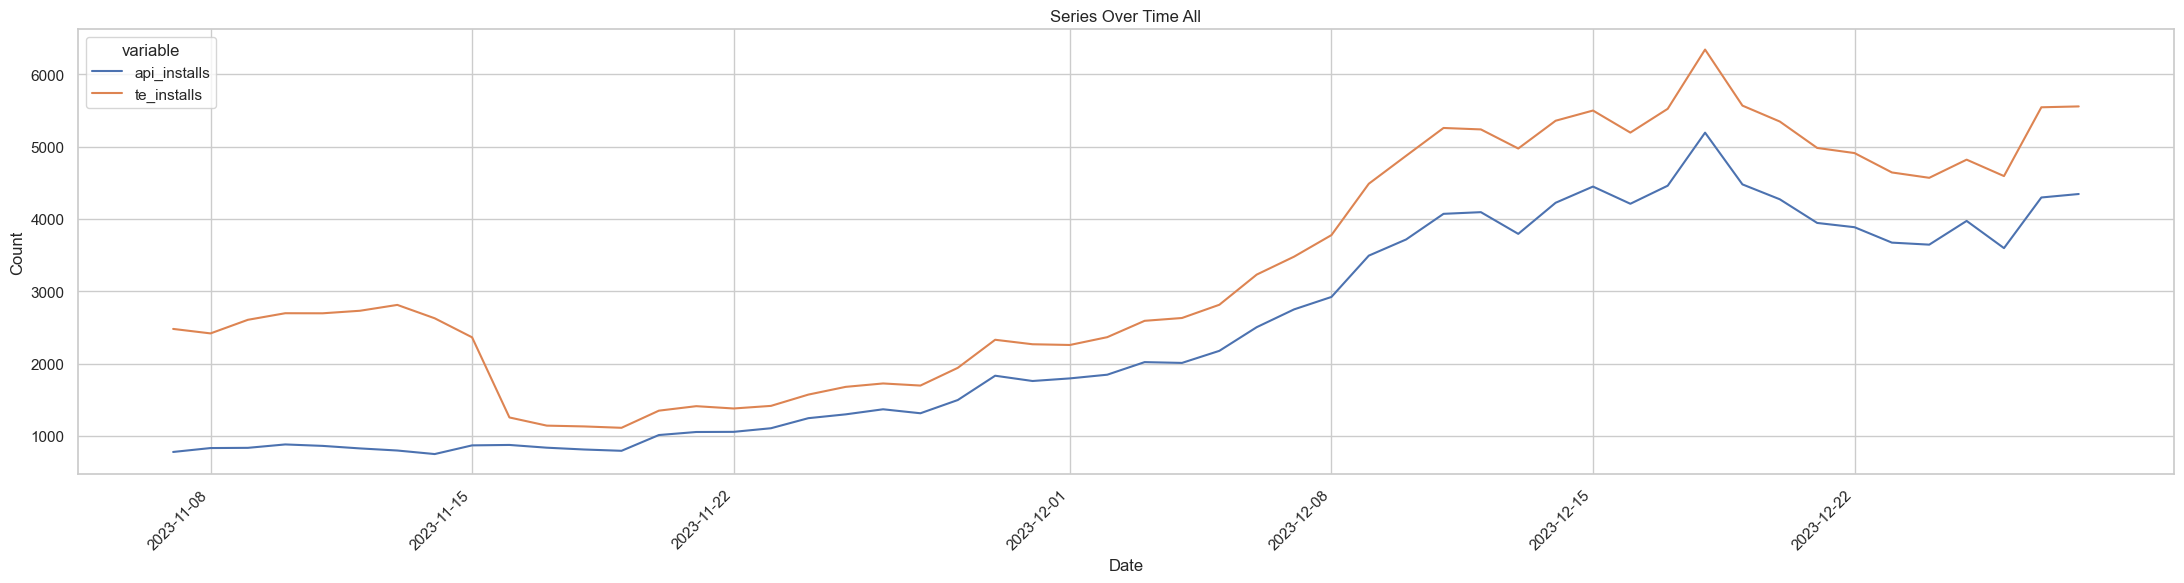

In [80]:

# Set the seaborn style
sns.set(style="whitegrid")

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date'], value_vars=['api_installs', 'te_installs'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time All')

# Display the legend
# plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

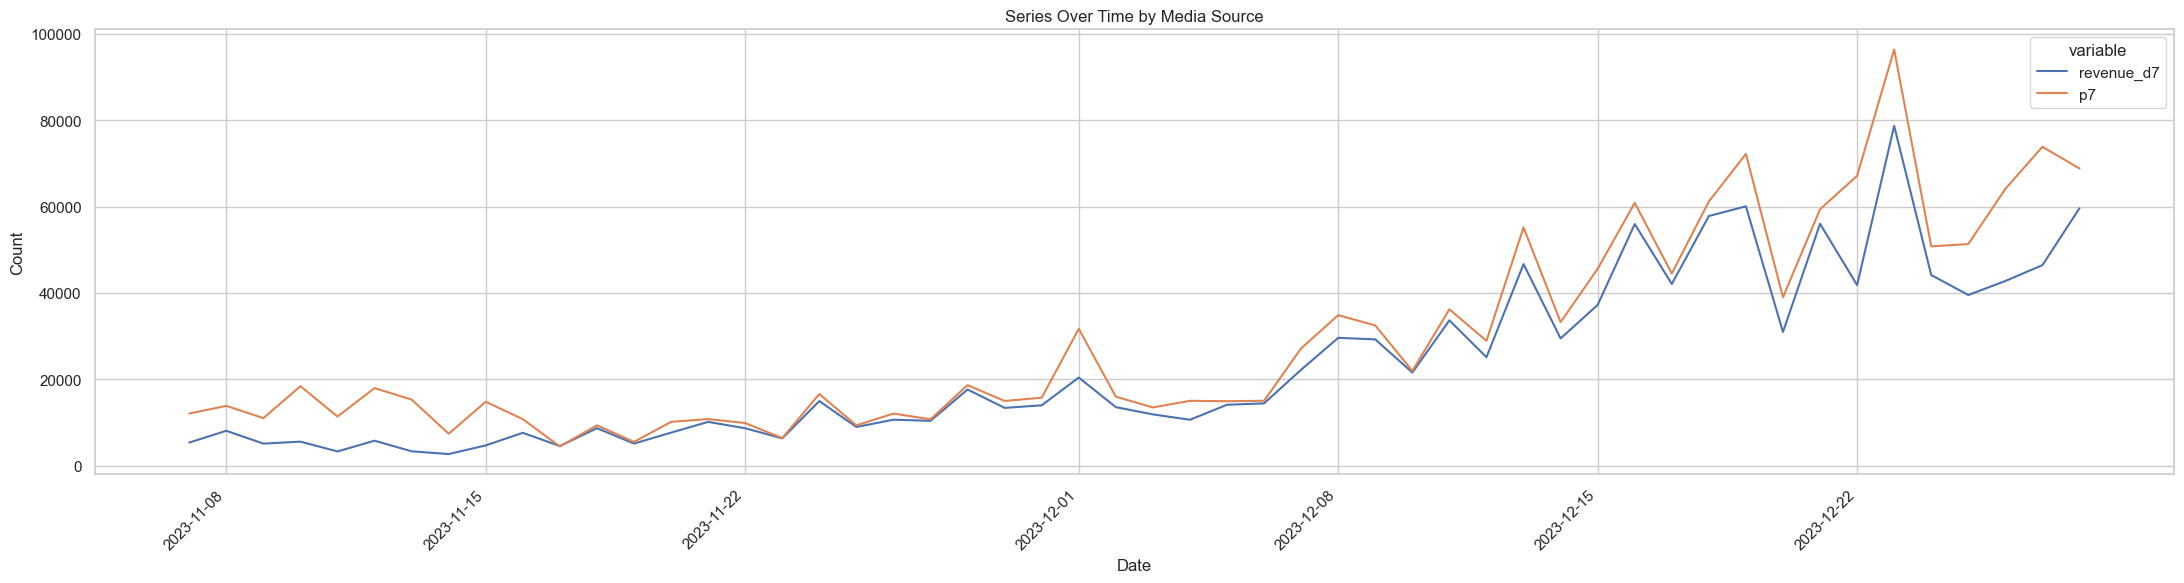

In [81]:
# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date'], value_vars=['revenue_d7', 'p7'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time by Media Source')

# Display the legend
# plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

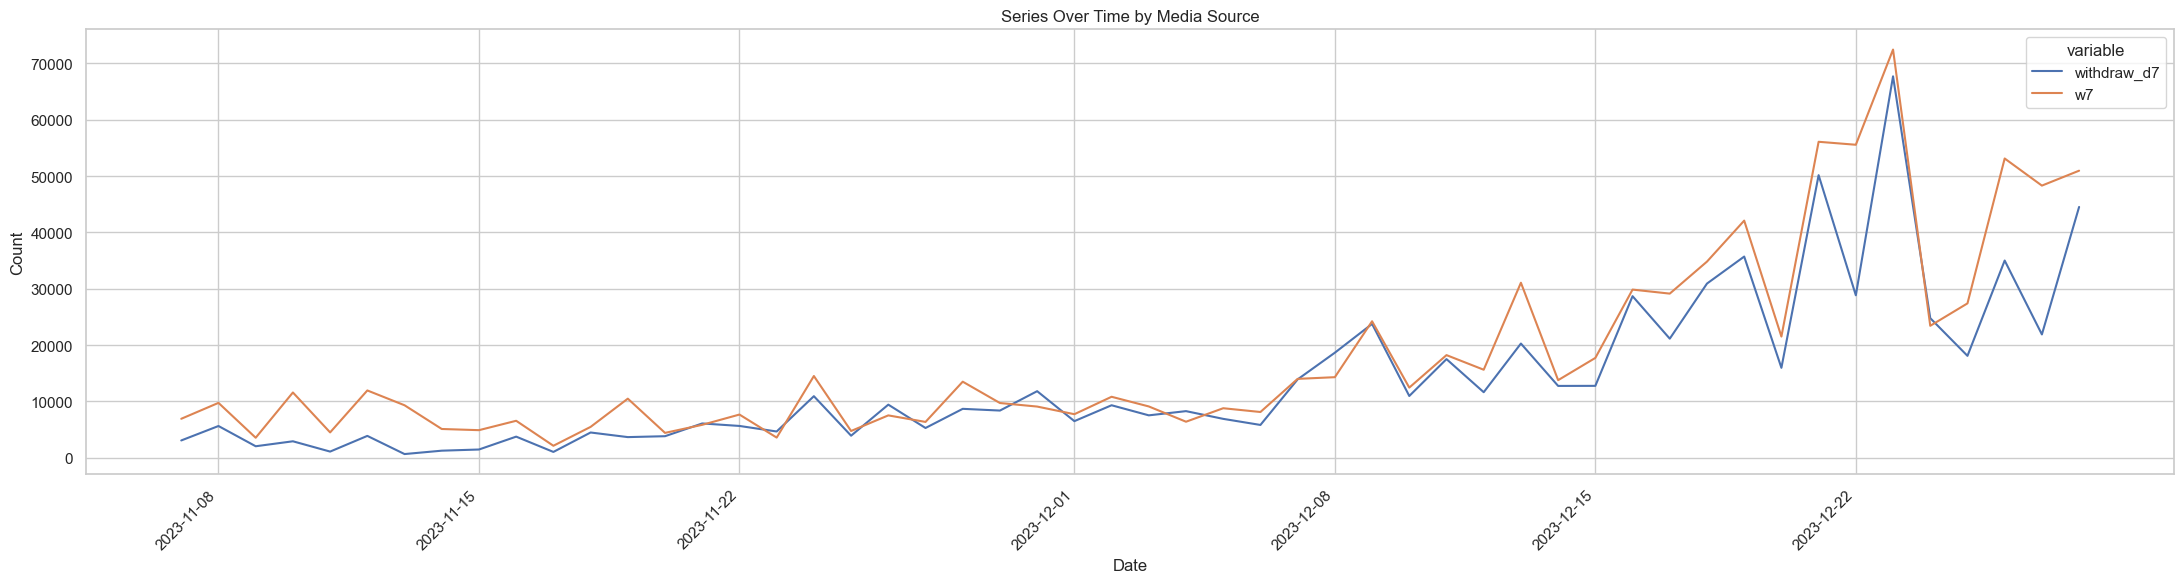

In [82]:
sns.set(style="whitegrid")

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date'], value_vars=['withdraw_d7', 'w7'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time by Media Source')

# Display the legend
# plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

## 3. Incorporate the responses from the BI tool 

In [83]:
file_path = (os.getcwd()).replace('\\', '/') + r'/roi_all_by_user_20240126114811.xlsx'.replace('\\', '/')
bi_tool_actuals = pd.read_excel(file_path)

bi_tool_actuals = bi_tool_actuals[bi_tool_actuals['date'] != '--']

In [84]:
bi_tool_actuals[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']].sort_values(by = 'date').head(10)

,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
71,20231108,"4,975.01 (36.28%)","7,668.44 (55.92%)","16,387.03 (119.5%)"
70,20231109,"2,298.62 (15.38%)","3,588.79 (24.01%)","4,962.28 (33.2%)"
69,20231110,"11,288.82 (69.2%)","25,256.77 (154.81%)","37,694.67 (231.05%)"
68,20231111,"2,622.44 (16.48%)","3,771.83 (23.71%)","9,822.25 (61.74%)"
67,20231112,"7,123.44 (42.87%)","10,995.05 (66.17%)","14,381.77 (86.56%)"
66,20231113,"2,641.14（15.98%）","4,017.01（24.31%）","5,039.40（30.5%）"
65,20231114,"2,633.08（15.81%）","3,847.72（23.11%）","4,954.05（29.75%）"
64,20231115,"1,956.68（11.26%）","2,283.08（13.14%）","3,897.57（22.44%）"
63,20231116,"2,587.26（16.46%）","4,044.17（25.72%）","5,351.50（34.04%）"
62,20231117,"3,549.81（19.97%）","4,594.79（25.85%）","6,578.70（37.01%）"


In [85]:
# Convert percentage strings to floats
def convert_percentage_string_to_float(percentage_string):
    try:
        return float(percentage_string.split(' ')[1][1:-2]) / 100
    except (ValueError, IndexError):
        return float(percentage_string.split('（')[1][0:-2]) / 100

for col in ['7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']:
    bi_tool_actuals[col] = bi_tool_actuals[col].apply(convert_percentage_string_to_float)

bi_tool_actuals[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']].sort_values(by = 'date').head(10)

,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
71,20231108,0.3628,0.5592,1.1950
70,20231109,0.1538,0.2401,0.3320
69,20231110,0.6920,1.5481,2.3105
68,20231111,0.1648,0.2371,0.6174
67,20231112,0.4287,0.6617,0.8656
66,20231113,0.1598,0.2431,0.3050
65,20231114,0.1581,0.2311,0.2975
64,20231115,0.1126,0.1314,0.2244
63,20231116,0.1646,0.2572,0.3404
62,20231117,0.1997,0.2585,0.3701


In [86]:
bi_tool_actuals['date'].max()
# bi_tool_actuals['date'].dtype

20240118

In [87]:
# MERGE BI TOOL TO MY DATA (AGG DF INCLUDES BI DATA)

bi_tool_wanted_cols = ['date', 'Recovery on the 28th (rate)']

# agg_df['channel'] = agg_df['media_source']
# bi_tool_actuals['date'] = pd.to_datetime(bi_tool_actuals['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
agg_df = pd.merge(agg_df, bi_tool_actuals[bi_tool_wanted_cols], on = 'date')
agg_df.sample(10)


,date,api_installs,cost,revenue_d7,withdraw_d7,p1,p10,p100,p105,p11,...,pred_28_133,pred_35_133,te_installs,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,return_p_d7,return_ad_d7,Recovery on the 28th (rate)
36,20231214,4223,53020.23,29471.48,12752.80,14966.56020,43178.16818,107788.74474,107788.74474,46642.71181,...,2.232956,2.481011,5357,-0.113646,5.978802,-0.211686,0.432717,0.627124,0.0,0.3882
14,20231122,1056,9057.12,8672.69,5648.90,4087.40089,12738.63348,52058.71710,52058.71710,13295.64748,...,3.725175,4.424888,1379,-0.121992,7.212775,-0.234228,0.651343,1.090600,0.0,0.3898
33,20231211,4070,43663.96,33666.44,17509.98,14080.86904,44212.94477,157192.40881,157192.40881,46761.95398,...,3.237598,3.889024,5257,-0.070305,7.271853,-0.225794,0.520102,0.829342,0.0,0.4304
31,20231209,3492,39196.44,29256.02,23753.68,13706.93757,46230.14972,334885.17955,334885.17955,55063.34435,...,6.289532,9.861995,4486,-0.099546,7.378013,-0.221578,0.811925,0.828909,0.0,0.1808
43,20231221,3944,57804.02,56023.51,50155.45,22122.67098,69481.17748,150792.03374,150792.03374,72510.78848,...,2.244514,2.718430,4981,-0.056601,13.204744,-0.208191,0.895257,1.027346,0.0,0.8694
21,20231129,1832,15308.02,13385.63,8379.39,5057.81100,20018.90599,139323.86513,139323.86513,21724.52999,...,3.927567,5.355404,2329,-0.107176,6.306567,-0.213396,0.625999,0.979386,0.0,0.2713
12,20231120,1012,8106.46,7655.95,3827.72,3055.78215,13236.64111,63003.15468,63003.15468,13747.02874,...,6.234769,7.579290,1349,-0.246024,6.565168,-0.249815,0.499967,1.252594,0.0,0.5278
5,20231113,798,6546.11,3331.90,659.26,6199.55097,19089.47842,118807.07840,118807.07840,19886.13142,...,10.603466,12.904006,2811,-0.782384,3.175313,-0.716115,0.197863,2.338936,0.0,0.3050
44,20231222,3885,57584.45,41825.53,28837.73,23708.44213,85893.89213,220859.82424,220859.82424,94341.22013,...,4.375487,4.750520,4910,-0.377087,9.765902,-0.208758,0.689477,1.166028,0.0,0.2780
34,20231212,4093,43707.59,25125.52,11637.15,10294.14720,38247.63186,162495.17853,162495.17853,41559.16470,...,3.253532,4.275256,5237,-0.131335,5.138656,-0.218446,0.463161,0.661768,0.0,0.5675


### Check the Joint results

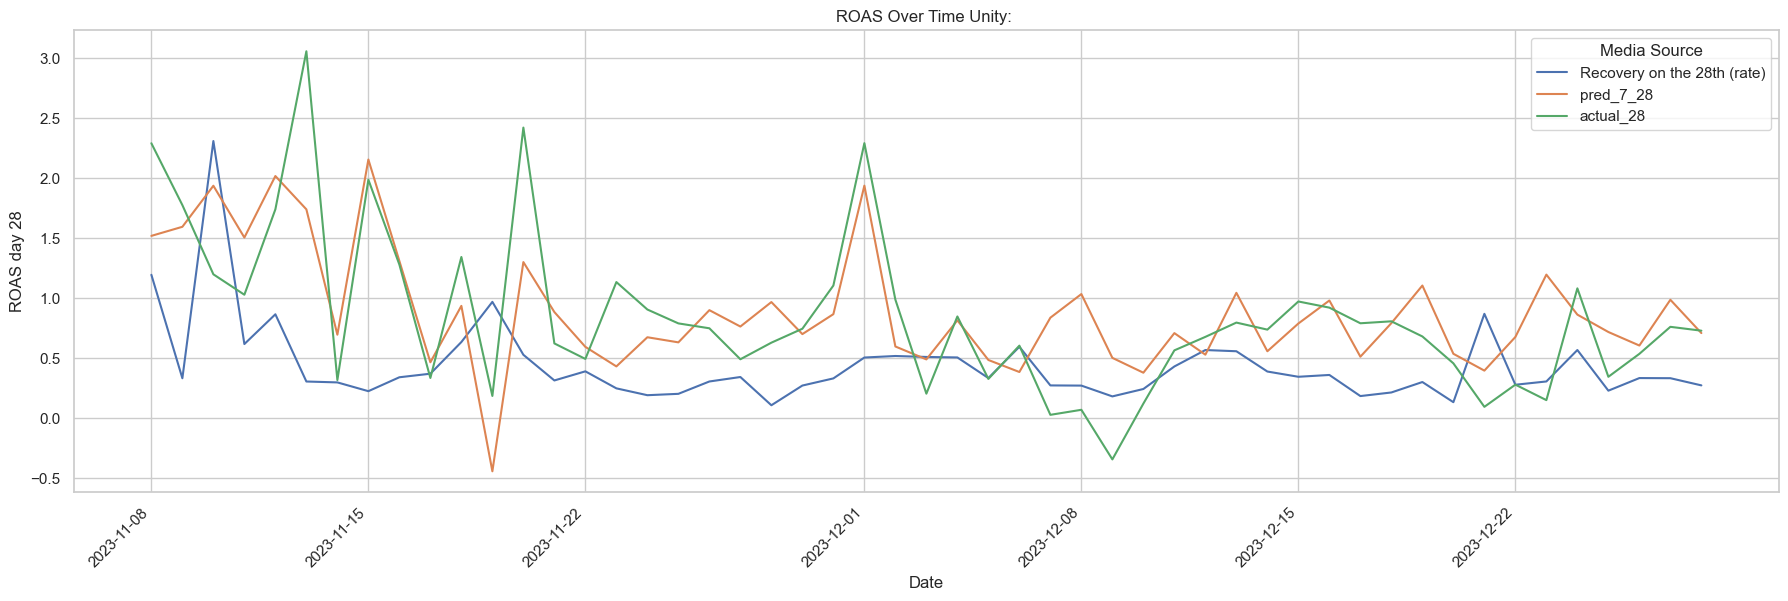

In [88]:
filtered_df = agg_df.copy()#[agg_df['channel'] == sourcesito]
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by='date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ')

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

## Find the best configuration to train correction rule

In [89]:
w_col_names = [col for col in agg_df.columns if re.match(r'^w\d*$', col) is not None]
p_col_names = [col for col in agg_df.columns if re.match(r'^p\d*$', col) is not None]
agg_df_train = agg_df[agg_df['api_installs'] > 50][['date'] + ['te_installs'] + ['cost'] + ['revenue_d7'] + ['withdraw_d7'] + ['payment_increase'] 
                        + ['rpi_increase'] + ['installs_difference'] + ['withdrawn_ratio'] + ['Recovery on the 28th (rate)']
                        + [col for col in agg_df.columns if col.startswith("pred_") ] + w_col_names + p_col_names]

agg_df_train['d7_28_increase_api'] = agg_df_train['Recovery on the 28th (rate)'] - agg_df_train['revenue_d7']/agg_df_train['cost']
agg_df_train['d7_28_increase_pred'] = agg_df_train['pred_7_28'] - (agg_df_train['p7']/agg_df_train['cost'] - agg_df_train['withdraw_d7']/agg_df_train['cost'])
agg_df_train['d7_28_increase_pred'] = agg_df_train['pred_7_28'] - (agg_df_train['p7']/agg_df_train['cost'] - agg_df_train['withdraw_d7']/agg_df_train['cost'])


In [90]:
# GET THE COLUMN GROUPS
validation_sets = 3
agg_df_train['validation_set_id'] = pd.qcut(agg_df_train['date'].astype(float).values, validation_sets)

In [91]:
agg_df_train.groupby('validation_set_id').size()

validation_set_id
(20231107.999, 20231124.667]    17
(20231124.667, 20231211.333]    17
(20231211.333, 20231228.0]      17
dtype: int64

In [92]:
# Check for nulls, infinities and select the model_cols
model_cols = agg_df_train[agg_df_train.columns[5:]].columns
model_cols
null_rows = agg_df_train[agg_df_train['payment_increase'].isnull()]
print(null_rows)
infinity_rows = agg_df_train[np.isinf(agg_df_train['payment_increase'])]
infinity_rows

Empty DataFrame
Columns: [date, te_installs, cost, revenue_d7, withdraw_d7, payment_increase, rpi_increase, installs_difference, withdrawn_ratio, Recovery on the 28th (rate), pred_7_14, pred_8_14, pred_9_14, pred_10_14, pred_11_14, pred_12_14, pred_13_14, pred_7_28, pred_8_28, pred_9_28, pred_10_28, pred_11_28, pred_12_28, pred_13_28, pred_14_28, pred_15_28, pred_16_28, pred_17_28, pred_18_28, pred_19_28, pred_20_28, pred_21_28, pred_22_28, pred_23_28, pred_24_28, pred_25_28, pred_26_28, pred_27_28, pred_7_56, pred_8_56, pred_9_56, pred_10_56, pred_11_56, pred_12_56, pred_13_56, pred_14_56, pred_15_56, pred_16_56, pred_17_56, pred_18_56, pred_19_56, pred_20_56, pred_21_56, pred_22_56, pred_23_56, pred_24_56, pred_25_56, pred_26_56, pred_27_56, pred_28_56, pred_35_56, pred_7_63, pred_8_63, pred_9_63, pred_10_63, pred_11_63, pred_12_63, pred_13_63, pred_14_63, pred_15_63, pred_16_63, pred_17_63, pred_18_63, pred_19_63, pred_20_63, pred_21_63, pred_22_63, pred_23_63, pred_24_63, pred_25_6

,date,te_installs,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,Recovery on the 28th (rate),...,p70,p77,p8,p84,p9,p91,p98,d7_28_increase_api,d7_28_increase_pred,validation_set_id


### Modelling

In [93]:
# Define predictive model and the polynomial transformation (This should be kept for the dictionary with the exception of the dynamic column. In this case: d7_28_increase_pred)

## Addition
agg_df_train['return_withdraw_d7'] = agg_df_train['withdraw_d7'] / agg_df_train['cost'] 
agg_df_train['return_p_d7'] = agg_df_train['p7'] / agg_df_train['cost'] 

## Definintion in list 
model_cols = ['return_withdraw_d7', 'return_p_d7', 'payment_increase', 'rpi_increase', 'installs_difference', 'withdrawn_ratio', 'd7_28_increase_api', 'd7_28_increase_pred', 'te_installs']

## Algorithm 
def create_huber(alpha, epsi, cols, weights_train): 
    
    columns = cols
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), columns)
        ],
        remainder='passthrough'
    )


    # Create the pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', HuberRegressor(fit_intercept = True, epsilon = epsi, alpha = alpha, warm_start = False, max_iter = 1000))
    ])

    pipe.named_steps['regressor'].sample_weight = weights_train

    return pipe

## Feat engineering
def all_feature_enginerring(data, pred_col):

    """
    This is better to create before and the just utilise it in whatever model
        - Notice what you're doing with withdrawal day 100 (I am not so interested in withdrawal but it is fine)
    """
    
    # Inclusion of interpolation 
    column_list = ['withdrawn_ratio', pred_col, 'installs_difference']
    column_combinations = list(itertools.combinations(column_list, 2))

    for pair in column_combinations:
        column1, column2 = pair
        new_column_name = f"{column1}_times_{column2}"
        data[new_column_name] = data[column1] * data[column2]  # Example: Multiply values of two columns

    return data


In [94]:
model_results = []
all_model_results = []
alphas = [0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2] 
epsils = [1, 1.05, 1.1, 1.3, 1.5, 1.7, 2, 2.5, 3] 

# for train_index, test_index in splits:
for date_group in tqdm(agg_df_train['validation_set_id'].unique()):
    
    print(date_group)

    train_data =  agg_df_train[agg_df_train['validation_set_id'] != date_group][model_cols]
    test_data =  agg_df_train[agg_df_train['validation_set_id'] == date_group][model_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'd7_28_increase_api']), train_data[f'd7_28_increase_api'] 
    X_test, y_test = test_data.drop(columns = [f'd7_28_increase_api']), test_data[f'd7_28_increase_api']

    old_cols = X_train[[col for col in X_train.columns if col != 'te_installs']].copy().columns
    X_train = all_feature_enginerring(X_train, 'd7_28_increase_pred')
    X_test = all_feature_enginerring(X_test, 'd7_28_increase_pred')

    weights_train = np.log1p(X_train['te_installs'])

    for alpha in alphas: 
        for epsi in epsils: 
            for cols in [old_cols, X_train.columns]:
                
                # Full trainning and testing 
                model = create_huber(alpha, epsi, old_cols, weights_train)
                model.fit(X_train[[col for col in cols if col != 'te_installs']], y_train)
                predictions = model.predict(X_test[[col for col in X_train.columns if col != 'te_installs']])
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)

                # Save the model into dictionary (Response, day, mo...)
                model_result = pd.DataFrame({
                    'Iteration': [str(alpha) + ' - ' + str(epsi) + ' - ' + str(len([col for col in cols if col != 'te_installs']))]
                    , 'Test at': [date_group]
                    , 'Model': [model]
                    , 'mae': [mae]
                    , 'r2': [r2]
                    , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
                })

                model_results.append(model_result)
    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)
all_model_results.shape[0]


  0%|          | 0/3 [00:00<?, ?it/s]

(20231107.999, 20231124.667]


 33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

(20231124.667, 20231211.333]


 67%|██████▋   | 2/3 [00:03<00:01,  1.85s/it]

(20231211.333, 20231228.0]


100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


864

In [95]:
all_model_results.sort_values(by = 'mae').head(5)

,Iteration,Test at,Model,mae,r2,rel_mae
424,0.2 - 1.7 - 7,"(20231124.667, 20231211.333]","(ColumnTransformer(remainder='passthrough',\n ...",0.148504,0.525187,0.376758
712,0.2 - 1.7 - 7,"(20231124.667, 20231211.333]","(ColumnTransformer(remainder='passthrough',\n ...",0.148504,0.525187,0.376758
694,0.15 - 1.7 - 7,"(20231124.667, 20231211.333]","(ColumnTransformer(remainder='passthrough',\n ...",0.148771,0.525235,0.375634
406,0.15 - 1.7 - 7,"(20231124.667, 20231211.333]","(ColumnTransformer(remainder='passthrough',\n ...",0.148771,0.525235,0.375634
676,0.1 - 1.7 - 7,"(20231124.667, 20231211.333]","(ColumnTransformer(remainder='passthrough',\n ...",0.149043,0.525274,0.374495


In [96]:
all_model_results.groupby('Iteration')[['mae', 'r2', 'rel_mae']].mean().sort_values(by = 'mae', ascending = True).head(10)

,mae,r2,rel_mae
Iteration,,,
0.2 - 3 - 7,0.313247,-0.099422,-0.030220
0.15 - 3 - 7,0.313456,-0.097738,-0.030836
0.1 - 3 - 7,0.313671,-0.096008,-0.031477
0.05 - 3 - 7,0.313880,-0.094155,-0.032097
0.02 - 3 - 7,0.314006,-0.093010,-0.032474
0.01 - 3 - 7,0.314048,-0.092610,-0.032596
0.005 - 3 - 7,0.314068,-0.092412,-0.032658
0 - 3 - 7,0.314089,-0.092212,-0.032720
0.2 - 3 - 10,0.328573,-0.245342,-0.095556


In [97]:
model_value = all_model_results.loc[all_model_results['Iteration'] == '0.2 - 1 - 10', 'Model'].iloc[0]
reset_df_plus = all_feature_enginerring(agg_df_train, 'd7_28_increase_pred')
cols_to_append = [
    'roas_d7_times_installs_difference',
    'withdrawn_ratio_times_installs_difference',
    'withdrawn_ratio_times_pred_7_28',
    'roas_d7_times_pred_7_28',
    'roas_d7_times_withdrawn_ratio',
    'pred_7_28_times_installs_difference'
]
cols_to_append = [
    'withdrawn_ratio_times_d7_28_increase_pred',
    'withdrawn_ratio_times_installs_difference',
    'd7_28_increase_pred_times_installs_difference']

subnormal = [col for col in old_cols if col != 'Installs']
subnormal.extend(cols_to_append)

predictions = model_value.predict(reset_df_plus[subnormal])

In [98]:
import plotly.express as px

# Assuming reset_df is your DataFrame
pdf = pd.DataFrame({'y_test': agg_df_train['d7_28_increase_api'].values, 'ROAS D7': (agg_df_train['revenue_d7']/agg_df_train['cost']), 'installs': agg_df_train['te_installs']})

# Create a scatter plot with size and color based on 'installs' and 'channel'
fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs ROAS day 7', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test'],
                 size='installs'
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

In [100]:
pdf = pd.DataFrame({'y_test': agg_df_train['d7_28_increase_api'].values, 'predictions': predictions, 'installs': agg_df_train['te_installs']})

fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs Predictions', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test'],
                 size='installs',  # Set size proportional to 'installs'
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

In [101]:
pdf = pd.DataFrame({'y_test': ((agg_df_train['revenue_d7'].values - agg_df_train['withdraw_d7'].values)/agg_df_train['cost'].values + agg_df_train['d7_28_increase_api'].values), 'predictions': ((agg_df_train['revenue_d7'].values - agg_df_train['withdraw_d7'].values)/agg_df_train['cost'].values + predictions)})

fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs Predictions', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test']
                )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

## Fit to dictionary based on availables

In [102]:
dev_df = agg_df_train.copy(deep = True)

columns_rule = ['revenue_d7','withdraw_d7','installs','payment_increase','rpi_increase','installs_difference','is_facebook','pred_roas','roas_d7','withdrawn_ratio']
columns_rule = ['revenue_d7','withdraw_d7','payment_increase','rpi_increase','installs_difference']

max_date = df['date'].max()
dev_df['days_since_install'] = (max_date - dev_df['date']) # Needed? Yes


In [103]:
payback_predictive_system = []

from tqdm import tqdm, tqdm_notebook

for y_day in tqdm(['14', '28']):
  for x_day in predictors_days:
    if int(y_day) > int(x_day):
  
      train = dev_df.copy()
      train['y'] = train['Recovery on the 28th (rate)'] - (train[f'p{x_day}'] - train[f'w{x_day}'])/train['cost']
      y = train[train['days_since_install'] <= (int(y_day) - 1)]['y'] # This is the regressors-based of d7_28_increment
      del train['y']
  
      # Make the regressors
      selected_columns = columns_rule + [f'pred_{x_day}_{y_day}']
      
      # Define X 
      X = train[train['days_since_install'] <= (int(y_day) - 1)]
      weights_train = np.log1p(X['te_installs'])
  
      # Define observation importance 0.01 - 1.05 - 160 - 1 - 10
      model = create_huber(0.0, 1.05, selected_columns, weights_train)
      model.fit(X[[col for col in selected_columns if col != 'te_installs']], y)
  
      # Save the model into dictionary (Response, day, model)
      payback = pd.DataFrame({
              'Available day': [x_day]
              , 'Target day': [y_day]
              , 'Model': [model]
              , 'Columns': [X[[col for col in selected_columns if col != 'te_installs']].columns]
              })
  
      payback_predictive_system.append(payback)

rules_dict = pd.concat(payback_predictive_system, ignore_index = True)
rules_dict

100%|██████████| 2/2 [00:00<00:00,  4.42it/s]


,Available day,Target day,Model,Columns
0,7,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
1,8,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
2,9,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
3,10,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
4,11,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
5,12,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
6,13,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
7,7,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
8,8,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
9,9,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."


In [104]:
dev_df_check = dev_df.copy(deep = True)

In [105]:
# Add predictions
integers_list = list(range(7, 28))
incremented_numbers = [str(number) for number in range(28, 36, 7)]
predictors_days_input = predictors_days = [str(integer) for integer in integers_list] + incremented_numbers

# Available dates as target (I am considering adding more values, above and below, maybe up to two on each side)
response_days_input = response_days = ["14", "28", "56", "63", "70", "77", "84", "91", "98", "100", "105", "112", "119", "126", "133"]

def add_predictions(data, model_dict, response_days, predictors_days):

    for response in response_days:

        data[f'actual_{response}'] = data[f'p{response}'] - data[f'w{response}']

        for reg in predictors_days:

            if int(response) > int(reg):
                                
                columns = list((model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)][['Columns']].reset_index(drop = True).values[0])[0]) #+ [f'p_last_diff_7_{reg}'] + [f'w_last_diff_7_{reg}']
    
                # Load the model
                model = model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)]['Model'].reset_index(drop = True).values[0]
    
                # Make the prediction (Make sure is done only for those on which makese sense)
                prediction = model.predict(data[columns])
                data[f'pred_{reg}_{response}_agg'] = prediction + (data[f'p{reg}']- data[f'w{reg}'])/data[f'cost']
                
    return data

dev_df_check = add_predictions(dev_df_check, rules_dict, ['28'], predictors_days_input)


In [106]:
dev_df_check.sample(6)

,date,te_installs,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,Recovery on the 28th (rate),...,pred_18_28_agg,pred_19_28_agg,pred_20_28_agg,pred_21_28_agg,pred_22_28_agg,pred_23_28_agg,pred_24_28_agg,pred_25_28_agg,pred_26_28_agg,pred_27_28_agg
4,20231112,2730,6357.49,5789.05,3883.02,-0.677854,6.000060,-0.697070,0.670753,0.8656,...,2.421619,2.754117,2.351796,2.104446,2.112749,1.822192,2.383822,2.898402,2.763233,2.252031
45,20231223,4642,59061.96,78702.36,67696.19,-0.183431,20.433105,-0.208962,0.860155,0.3054,...,0.305400,0.305400,0.305400,0.305400,0.305400,0.305400,0.305400,0.305400,0.305400,0.305400
44,20231222,4910,57584.45,41825.53,28837.73,-0.377087,9.765902,-0.208758,0.689477,0.2780,...,0.188211,0.192005,0.247772,0.182971,0.243844,0.207034,0.207336,0.179423,0.173619,0.197554
48,20231226,4592,63086.76,42776.45,35004.30,-0.332715,10.895565,-0.216899,0.818308,0.3337,...,0.333700,0.333700,0.333700,0.333700,0.333700,0.348857,0.366065,0.366575,0.333700,0.333700
15,20231123,1415,10238.10,6325.87,4663.57,-0.009124,4.719593,-0.218375,0.737222,0.2479,...,0.554079,0.548327,0.557832,0.566301,0.569154,0.583474,0.581430,0.570868,0.567349,0.593423
38,20231216,5193,53679.00,55968.22,28679.86,-0.080520,12.297273,-0.189486,0.512431,0.3596,...,0.359600,0.349346,0.334284,0.310860,0.346893,0.359600,0.359600,0.359600,0.327942,0.344175


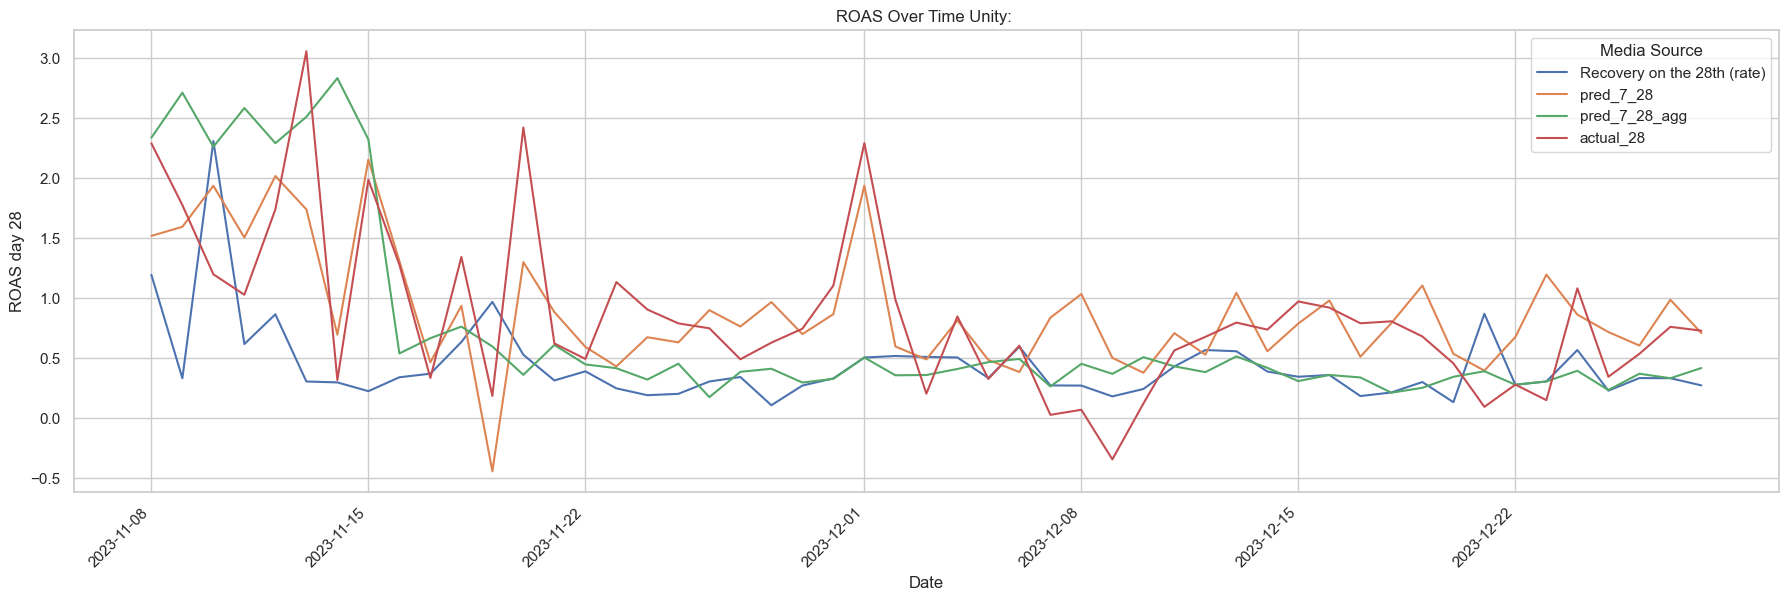

In [107]:
### Check the Joint results

filtered_df = dev_df_check.copy()
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by = 'date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'pred_7_28_agg', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ')

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [108]:
# Remove the last data points and remove the pred_ columns. This is too much
with open('acorn_games_ios_ptlv_dictionary_2024.pkl', 'wb') as file:
    pickle.dump(rules_dict, file)